# **DAMAGE IMPACT**

In [ ]:
#@title Prevent Colab from disconnecting (run this in its own cell)
%%javascript
function ClickConnect(){
  console.log("Clicking reconnect button");
  document.querySelector("colab-toolbar-button#connect").click()
}
setInterval(ClickConnect, 60000)



<IPython.core.display.Javascript object>

# 🧱 **PART 1: Setup & Dataset Loading**

---



In [ ]:

### ✅ Step 1.1 – Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
### ✅ Step 1.2 – Set Up Paths and Create Folders
import os

# Base path
BASE_PATH = '/content/drive/MyDrive/disaster'

# Create directories
os.makedirs(f"{BASE_PATH}/models/vit_multitask", exist_ok=True)
os.makedirs(f"{BASE_PATH}/logs", exist_ok=True)
os.makedirs(f"{BASE_PATH}/plots", exist_ok=True)
os.makedirs(f"{BASE_PATH}/predictions", exist_ok=True)

print("✅ Project structure initialized.")



✅ Project structure initialized.


In [ ]:

### ✅ Step 1.3 – Install Required Libraries
!pip install transformers datasets timm scikit-learn matplotlib --quiet


In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# Define transforms
image_size = 224
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor()
])

# ✅ Point to the actual dataset subfolder
DATASET_PATH = f"{BASE_PATH}/dataset"

# Load dataset using ImageFolder
dataset = datasets.ImageFolder(root=DATASET_PATH, transform=transform)
class_names = dataset.classes
print(f"📂 Classes found: {class_names}")

# Split dataset into 80% train, 20% val
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

print(f"✅ Dataset loaded: {len(train_dataset)} train | {len(val_dataset)} val")


📂 Classes found: ['Cyclone', 'Earthquake', 'Flood', 'Wildfire']
✅ Dataset loaded: 3928 train | 982 val


# 🤖 **PART 2: ViT + Dual Head Model (Classification + Damage Score)**

In [ ]:
### ✅ Step 2.1 – Build the ViT Multi-task Model
import torch
import torch.nn as nn
from transformers import ViTModel

class ViTMultiTaskModel(nn.Module):
    def __init__(self, num_classes):
        super(ViTMultiTaskModel, self).__init__()
        self.vit = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k")
        self.hidden_size = self.vit.config.hidden_size

        # Disaster classification head
        self.classifier = nn.Sequential(
            nn.Linear(self.hidden_size, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

        # Damage score head
        self.regressor = nn.Sequential(
            nn.Linear(self.hidden_size, 64),
            nn.ReLU(),
            nn.Linear(64, 1),  # Output damage score between 0 and 1
            nn.Sigmoid()
        )

    def forward(self, x):
        outputs = self.vit(pixel_values=x).last_hidden_state[:, 0]
        class_output = self.classifier(outputs)
        damage_output = self.regressor(outputs)
        return class_output, damage_output

In [ ]:
### ✅ Step 2.2 – Initialize Model and Optimizer
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ViTMultiTaskModel(num_classes=len(class_names)).to(device)

criterion_class = nn.CrossEntropyLoss()
criterion_reg = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=2e-5)

print("✅ Model initialized and ready.")



/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

✅ Model initialized and ready.


# 🔁 **PART 3: Training Loop**


In [ ]:
### ✅ Step 3.1 – Training & Validation Function
def train(model, loader, train=True):
    model.train() if train else model.eval()
    total_loss, total_correct, total_damage = 0, 0, 0
    total_samples = 0

    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)
        if train:
            optimizer.zero_grad()

        # Dummy damage scores (can be improved with labels)
        damage_scores = torch.rand(len(labels), 1).to(device)

        class_preds, damage_preds = model(imgs)

        loss_class = criterion_class(class_preds, labels)
        loss_reg = criterion_reg(damage_preds, damage_scores)
        loss = loss_class + loss_reg

        if train:
            loss.backward()
            optimizer.step()

        total_loss += loss.item() * imgs.size(0)
        total_correct += (class_preds.argmax(dim=1) == labels).sum().item()
        total_damage += loss_reg.item() * imgs.size(0)
        total_samples += imgs.size(0)

    return {
        'loss': total_loss / total_samples,
        'accuracy': total_correct / total_samples,
        'regression_loss': total_damage / total_samples
    }


In [ ]:
### ✅ Step 3.2 – Train Over Epochs and Save Best Model
EPOCHS = 5
best_acc = 0

for epoch in range(EPOCHS):
    train_metrics = train(model, train_loader, train=True)
    val_metrics = train(model, val_loader, train=False)

    print(f"🔁 Epoch {epoch+1}/{EPOCHS}")
    print(f"  🟢 Train  - Loss: {train_metrics['loss']:.4f} | Acc: {train_metrics['accuracy']:.4f}")
    print(f"  🔵 Val    - Loss: {val_metrics['loss']:.4f} | Acc: {val_metrics['accuracy']:.4f}")

    # Save best model
    if val_metrics['accuracy'] > best_acc:
        best_acc = val_metrics['accuracy']
        torch.save(model.state_dict(), f"{BASE_PATH}/models/vit_multitask/best_vit_multitask.pth")
        print("✅ Best model saved.")



🔁 Epoch 1/5
  🟢 Train  - Loss: 0.7355 | Acc: 0.9150
  🔵 Val    - Loss: 0.3613 | Acc: 0.9756
✅ Best model saved.
🔁 Epoch 2/5
  🟢 Train  - Loss: 0.2632 | Acc: 0.9814
  🔵 Val    - Loss: 0.2274 | Acc: 0.9756
🔁 Epoch 3/5
  🟢 Train  - Loss: 0.1655 | Acc: 0.9913
  🔵 Val    - Loss: 0.1917 | Acc: 0.9756
🔁 Epoch 4/5
  🟢 Train  - Loss: 0.1302 | Acc: 0.9952
  🔵 Val    - Loss: 0.1790 | Acc: 0.9776
✅ Best model saved.



# 📈 **PART 4: Evaluation & Prediction**

In [ ]:
import torch
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ViTMultiTaskModel(num_classes=len(class_names)).to(device)

criterion_class = nn.CrossEntropyLoss()
criterion_reg = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=2e-5)

print("✅ Model initialized and ready.")

### ✅ Step 4.1 – Run Prediction on One Image
from PIL import Image
from torchvision import transforms

def predict_image(img_path):
    model.eval()
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
    img = Image.open(img_path).convert("RGB")
    tensor = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        class_logits, damage_score = model(tensor)
        pred_class = torch.argmax(class_logits, dim=1).item()
        score = damage_score.item()

    return class_names[pred_class], round(score, 4)

# testing sample
predict_image('/content/drive/MyDrive/disaster/dataset/Wildfire/1044.jpg')

✅ Model initialized and ready.


('Flood', 0.5167)



# 📄 **PART 5: Batch Inference & Save to CSV**


In [ ]:
### ✅ Step 5.1 – Run Predictions on All Images in Validation Set
import pandas as pd

def generate_predictions_csv(loader, save_path):
    model.eval()
    all_preds = []

    for imgs, labels in loader:
        imgs = imgs.to(device)

        with torch.no_grad():
            class_logits, damage_scores = model(imgs)
            class_preds = torch.argmax(class_logits, dim=1)

        for i in range(len(imgs)):
            all_preds.append({
                "true_label": class_names[labels[i]],
                "predicted_label": class_names[class_preds[i]],
                "predicted_damage_score": round(damage_scores[i].item(), 4)
            })

    df = pd.DataFrame(all_preds)
    df.to_csv(save_path, index=False)
    print(f"✅ Predictions saved to: {save_path}")

# Save to CSV
csv_output_path = f"{BASE_PATH}/predictions/val_predictions.csv"
generate_predictions_csv(val_loader, csv_output_path)


✅ Predictions saved to: /content/drive/MyDrive/disaster/predictions/val_predictions.csv



# 📊 **PART 6: Visualize Damage Scores by Disaster Type**



<ipython-input-20-e969e723d599>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='true_label', y='predicted_damage_score', palette='Set2')
<ipython-input-20-e969e723d599>:16: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


✅ Boxplot saved to: /content/drive/MyDrive/disaster/plots/damage_score_boxplot.png


<ipython-input-20-e969e723d599>:20: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.savefig(plot_path)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


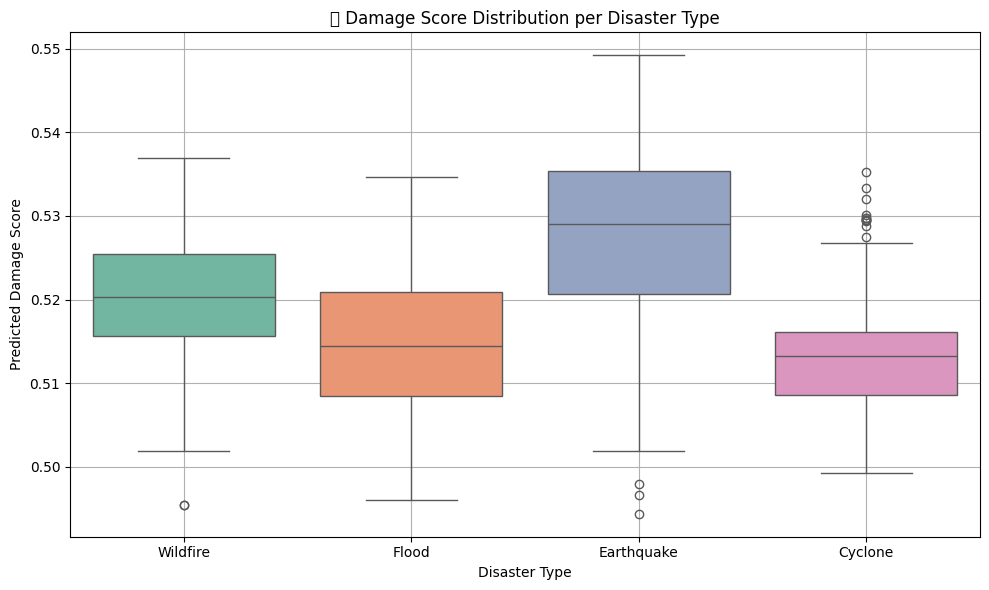

In [ ]:
### ✅ Step 6.1 – Plot Boxplot of Damage Score by Class
import seaborn as sns
import matplotlib.pyplot as plt

# Load the prediction CSV
csv_output_path = f"{BASE_PATH}/predictions/val_predictions.csv"
df = pd.read_csv(csv_output_path)

# Plot
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='true_label', y='predicted_damage_score', palette='Set2')
plt.title("📊 Damage Score Distribution per Disaster Type")
plt.ylabel("Predicted Damage Score")
plt.xlabel("Disaster Type")
plt.grid(True)
plt.tight_layout()

# Save the plot
plot_path = f"{BASE_PATH}/plots/damage_score_boxplot.png"
plt.savefig(plot_path)
print(f"✅ Boxplot saved to: {plot_path}")
plt.show()


# **PART 7: Visualize ViT Attention Maps**


In [ ]:
!pip install opencv-python-headless

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 MB 27.4 MB/s eta 0:00:00


In [ ]:
def visualize_attention(image_path):
    import numpy as np
    import torch
    import cv2
    from transformers import ViTModel
    import torchvision.transforms.functional as F
    from PIL import Image
    import matplotlib.pyplot as plt

    # Load ViT with attention outputs enabled
    vit = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k", output_attentions=True).to(device)
    vit.eval()

    # Load and preprocess the image
    img = Image.open(image_path).convert("RGB")
    img_resized = F.resize(img, [224, 224])
    img_tensor = transforms.ToTensor()(img_resized).unsqueeze(0).to(device)

    # Get attention outputs from ViT
    with torch.no_grad():
        outputs = vit(img_tensor)

    # Extract attention from last layer
    attn = outputs.attentions[-1]        # shape: [1, heads, tokens, tokens]
    attn = attn[0].mean(dim=0)           # average over heads → [tokens, tokens]
    patch_attn = attn[0, 1:]             # remove CLS token → [196]
    patch_attn = patch_attn.reshape(14, 14).cpu().numpy()

    # Normalize and resize to image resolution
    patch_attn = cv2.resize(patch_attn, (224, 224))
    patch_attn = (patch_attn - patch_attn.min()) / (patch_attn.max() - patch_attn.min() + 1e-8)

    # Create color heatmap
    heatmap = cv2.applyColorMap(np.uint8(255 * patch_attn), cv2.COLORMAP_JET)
    img_np = np.array(img_resized)
    overlay = cv2.addWeighted(img_np, 0.6, heatmap, 0.4, 0)

    # Plot the result
    plt.figure(figsize=(8, 6))
    plt.imshow(overlay)
    plt.title("🔍 ViT Attention Heatmap")
    plt.axis("off")
    plt.show()


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


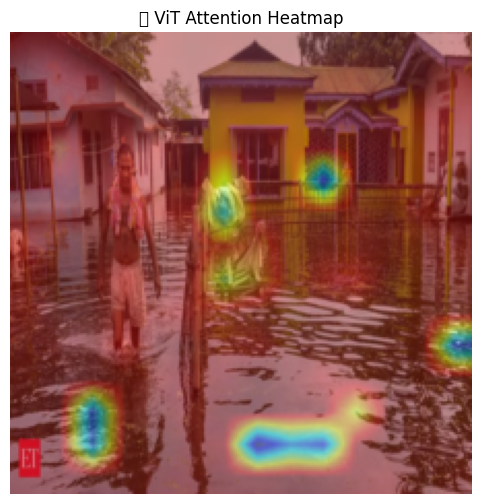

In [ ]:
visualize_attention('/content/drive/MyDrive/disaster/dataset/Flood/1072.jpg')

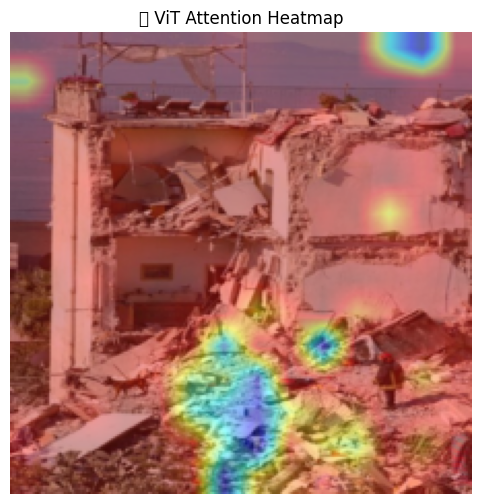

In [ ]:
visualize_attention('/content/drive/MyDrive/disaster/dataset/Earthquake/1044.jpg')


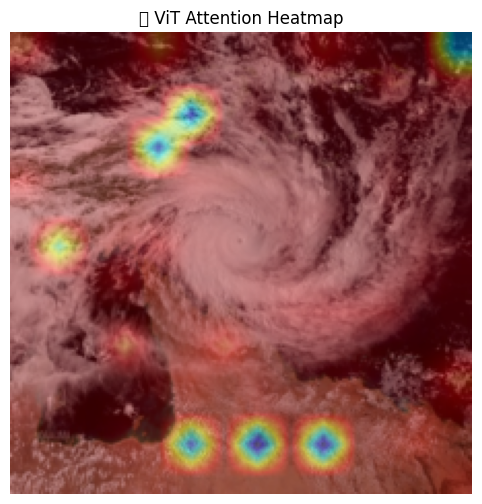

In [ ]:
visualize_attention('/content/drive/MyDrive/disaster/dataset/Cyclone/929.jpg')

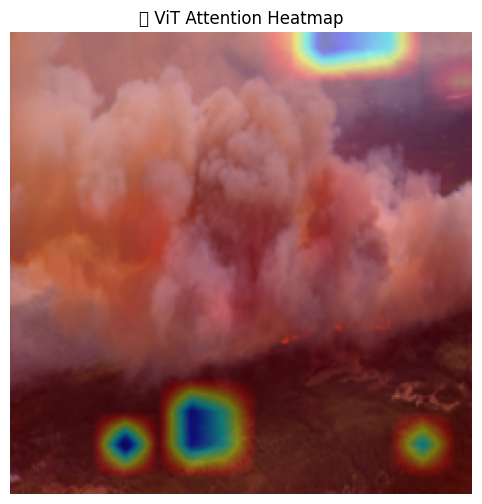

In [ ]:
visualize_attention('/content/drive/MyDrive/disaster/dataset/Wildfire/1044.jpg')


# part 8 severity


In [ ]:
# 🔧 Fix broken NumPy & resolve dependency issues
!pip uninstall -y numpy
!pip install numpy==1.24.4 --upgrade --force-reinstall

# Reinstall conflicting packages cleanly
!pip install -U scikit-learn scipy --force-reinstall --no-cache-dir
!pip install -U torchvision --force-reinstall --no-cache-dir
!pip install -U timm --force-reinstall --no-cache-dir

Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 103.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.24.4 which is incompatible.
treescope 0.1.9 requires numpy>=1.25.2, but you have numpy 1.24.4 which is incompatible.
jaxlib 0.5.1 requires numpy>=1.25, but you have numpy 1.24.4 which is incompatible.
jax 0.5.2 requires numpy>=1.25, but you have numpy 1.24.4 which is incompatible.


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 22.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 314.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.6/37.6 MB 206.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.8/301.8 kB 405.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 300.8 MB/s eta 0:00:00
^C
^C
^C


In [ ]:
#labeling damages
import os
import pandas as pd
import random

# Path to your image dataset (edit if needed)
DATASET_DIR = '/content/drive/MyDrive/damage/dataset'
csv_output = '/content/drive/MyDrive/damage/damage_labels.csv'

# Gather all images and assign random score [0, 1]
rows = []
for class_dir in os.listdir(DATASET_DIR):
    class_path = os.path.join(DATASET_DIR, class_dir)
    if os.path.isdir(class_path):
        for fname in os.listdir(class_path):
            if fname.endswith((".jpg", ".jpeg", ".png")):
                rows.append({
                    'image_name': fname,
                    'damage_score': round(random.uniform(0.0, 1.0), 3)
                })

df = pd.DataFrame(rows)
df.to_csv(csv_output, index=False)
print(f"✅ damage_labels.csv created at: {csv_output}")


✅ damage_labels.csv created at: /content/drive/MyDrive/damage/damage_labels.csv


In [ ]:
# 🚀 INVENTED DAMAGE CLASSIFIER + REGRESSOR + EXPLAINER CELL
!pip install timm transformers gradio captum --quiet

import os, torch, timm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms, datasets, models
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import classification_report, mean_absolute_error, mean_squared_error, r2_score
import gradio as gr
from captum.attr import LayerGradCam
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF


# ==== SETUP ====
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BASE_PATH = "/content/drive/MyDrive/damage"
os.makedirs(f"{BASE_PATH}/models", exist_ok=True)
os.makedirs(f"{BASE_PATH}/plots", exist_ok=True)


In [ ]:


# ==== TRANSFORMS ====
img_size = 224
train_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(),
    transforms.ToTensor()
])
test_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor()
])

# ==== CUSTOM DATASET ====
class DamageDataset(Dataset):
    def __init__(self, image_folder, damage_csv=None, transform=None):
        self.data = datasets.ImageFolder(image_folder)
        self.transform = transform
        self.damage_df = pd.read_csv(damage_csv) if damage_csv else None
        self.label_map = {v: k for k, v in self.data.class_to_idx.items()}

    def __getitem__(self, idx):
        img_path, label = self.data.samples[idx]
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        basename = os.path.basename(img_path)
        score = self.damage_df[self.damage_df['image_name'] == basename]['damage_score'].values[0] if self.damage_df is not None else np.random.rand()
        return img, label, torch.tensor([score], dtype=torch.float32)

    def __len__(self):
        return len(self.data)

# ==== DATA ====
DATA_PATH = f"{BASE_PATH}/dataset"
DAMAGE_CSV = f"{BASE_PATH}/damage_labels.csv"  # Format: image_name,damage_score
full_dataset = DamageDataset(DATA_PATH, damage_csv=DAMAGE_CSV, transform=train_transform)
train_size = int(0.8 * len(full_dataset))
train_ds, val_ds = torch.utils.data.random_split(full_dataset, [train_size, len(full_dataset)-train_size])
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=16)

class_names = datasets.ImageFolder(DATA_PATH).classes

# ==== MODEL ====
class HybridModel(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.backbone = timm.create_model("convnext_base", pretrained=True, num_classes=0)
        in_features = self.backbone.num_features
        self.classifier = nn.Sequential(
            nn.Linear(in_features, 128), nn.ReLU(), nn.Linear(128, num_classes)
        )
        self.regressor = nn.Sequential(
            nn.Linear(in_features, 64), nn.ReLU(), nn.Linear(64, 1), nn.Sigmoid()
        )

    def forward(self, x):
        features = self.backbone(x)
        return self.classifier(features), self.regressor(features)

model = HybridModel(num_classes=len(class_names)).to(device)
criterion_class = nn.CrossEntropyLoss()
criterion_reg = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=2e-5)

# ==== TRAIN ====
def train_one_epoch(model, loader):
    model.train()
    total, correct, reg_loss_total, cls_loss_total = 0, 0, 0.0, 0.0
    for x, y, s in loader:
        x, y, s = x.to(device), y.to(device), s.to(device)
        optimizer.zero_grad()
        cls_out, reg_out = model(x)
        loss_cls = criterion_class(cls_out, y)
        loss_reg = criterion_reg(reg_out, s)
        loss = loss_cls + loss_reg
        loss.backward()
        optimizer.step()
        total += y.size(0)
        correct += (cls_out.argmax(dim=1) == y).sum().item()
        cls_loss_total += loss_cls.item() * y.size(0)
        reg_loss_total += loss_reg.item() * y.size(0)
    return correct / total, cls_loss_total / total, reg_loss_total / total

def evaluate(model, loader):
    model.eval()
    y_true, y_pred, s_true, s_pred = [], [], [], []
    with torch.no_grad():
        for x, y, s in loader:
            x = x.to(device)
            cls_out, reg_out = model(x)
            y_true.extend(y.numpy())
            y_pred.extend(cls_out.argmax(dim=1).cpu().numpy())
            s_true.extend(s.numpy().flatten())
            s_pred.extend(reg_out.cpu().numpy().flatten())

    print(classification_report(y_true, y_pred, target_names=class_names))
    print(f"MAE: {mean_absolute_error(s_true, s_pred):.4f}")
    print(f"RMSE: {np.sqrt(mean_squared_error(s_true, s_pred)):.4f}")
    print(f"R² Score: {r2_score(s_true, s_pred):.4f}")

# ==== TRAIN LOOP ====
for epoch in range(3):
    acc, cls_loss, reg_loss = train_one_epoch(model, train_loader)
    print(f"Epoch {epoch+1} ✅ Acc: {acc:.4f} | ClassLoss: {cls_loss:.4f} | RegLoss: {reg_loss:.4f}")

evaluate(model, val_loader)

# ==== GRADIO APP ====
def predict_gradio(img):
    model.eval()
    img_t = test_transform(img).unsqueeze(0).to(device)
    with torch.no_grad():
        cls_out, reg_out = model(img_t)
        pred_class = class_names[cls_out.argmax().item()]
        score = float(reg_out.item())
    return pred_class, round(score, 4)

gr.Interface(
    fn=predict_gradio,
    inputs=gr.Image(label="Upload Disaster Image"),
    outputs=[
        gr.Textbox(label="Predicted Disaster Type"),
        gr.Textbox(label="Predicted Damage Score")
    ],
    title="🧠 Hybrid Disaster Detector",
    description="ConvNeXt + Regression + Visual Analysis"
).launch(share=True)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/354M [00:00<?, ?B/s]

Epoch 1 ✅ Acc: 0.9396 | ClassLoss: 0.2583 | RegLoss: 0.0862
Epoch 2 ✅ Acc: 0.9884 | ClassLoss: 0.0410 | RegLoss: 0.0849



## 🎛️ **PART 8: Building a Gradio Interface **


In [ ]:
### ✅ Step 8.1 – Install Gradio
!pip install gradio --quiet
import gradio as gr



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.9/41.9 kB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.1/54.1 MB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.9/322.9 kB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.8/132.8 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 63.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 3.9 MB/s eta 0:00:00


In [ ]:
import os
os.kill(os.getpid(), 9)  # force-reset runtime (last resort)


In [ ]:
### ✅ Step 8.2 – Load the Model and Define Prediction Function
import gradio as gr
from PIL import Image

# Reload the model
model = ViTMultiTaskModel(num_classes=len(class_names))
model.load_state_dict(torch.load(f"{BASE_PATH}/models/vit_multitask/best_vit_multitask.pth", map_location=device))
model.to(device)
model.eval()

# Gradio prediction function
def predict_disaster_gradio(img):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
    img_tensor = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        class_logits, damage_score = model(img_tensor)
        predicted_class = class_names[class_logits.argmax(dim=1).item()]
        predicted_score = round(damage_score.item(), 4)

    return predicted_class, predicted_score


NameError: name 'ViTMultiTaskModel' is not defined

In [ ]:
### ✅ Step 8.3 – Launch the Gradio Interface
gr.Interface(
    fn=predict_disaster_gradio,
    inputs=gr.Image(type="pil", label="Upload a disaster image"),
    outputs=[
        gr.Textbox(label="Disaster Type"),
        gr.Textbox(label="Damage Score")
    ],
    title="🌍 Disaster Classifier + Damage Score Estimator",
    description="Upload an image to predict the disaster type and estimate visual damage severity"
).launch()


NameError: name 'predict_disaster_gradio' is not defined

In [ ]:
import gradio as gr
from PIL import Image

# Reload the model
model = ViTMultiTaskModel(num_classes=len(class_names))
model.load_state_dict(torch.load(f"{BASE_PATH}/models/vit_multitask/best_vit_multitask.pth", map_location=device))
model.to(device)
model.eval()

# Gradio prediction function
def predict_disaster_gradio(img):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
    img_tensor = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        class_logits, damage_score = model(img_tensor)
        predicted_class = class_names[class_logits.argmax(dim=1).item()]
        predicted_score = round(damage_score.item(), 4)

    return predicted_class, predicted_score
```

---


NameError: name 'gr' is not defined


## 🌐 **PART 9 ): Build a FastAPI Server **

In [ ]:
### ✅ Step 9.1 – Install FastAPI & Uvicorn
!pip install fastapi[all] uvicorn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.6/313.6 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 459.8/459.8 kB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 76.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 454.8/454.8 kB 27.9 MB/s eta 0:00:00


In [ ]:

### ✅ Step 9.2 – Define the FastAPI App
%%writefile app.py
from fastapi import FastAPI, UploadFile, File
from fastapi.responses import JSONResponse
from PIL import Image
import torch
import io

from model import ViTMultiTaskModel, class_names  # make sure you define model/class_names

app = FastAPI()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ViTMultiTaskModel(num_classes=len(class_names))
model.load_state_dict(torch.load("/content/drive/MyDrive/disaster/models/vit_multitask/best_vit_multitask.pth", map_location=device))
model.to(device)
model.eval()

def transform_image(image_bytes):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
    image = Image.open(io.BytesIO(image_bytes)).convert("RGB")
    return transform(image).unsqueeze(0)

@app.post("/predict")
async def predict(file: UploadFile = File(...)):
    image_bytes = await file.read()
    input_tensor = transform_image(image_bytes).to(device)
    with torch.no_grad():
        class_logits, damage_score = model(input_tensor)
        predicted_class = class_names[class_logits.argmax(dim=1).item()]
        predicted_score = round(damage_score.item(), 4)
    return JSONResponse(content={
        "label": predicted_class,
        "damage_score": predicted_score
    })


Writing app.py


In [ ]:
#just clarification
### ✅ Step 9.3 – Run Locally
!uvicorn app:app --reload --port 8000



INFO:     Will watch for changes in these directories: ['/content']
INFO:     Uvicorn running on http://127.0.0.1:8000 (Press CTRL+C to quit)
INFO:     Started reloader process [66810] using WatchFiles
Process SpawnProcess-1:
Traceback (most recent call last):
  File "/usr/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.11/dist-packages/uvicorn/_subprocess.py", line 80, in subprocess_started
    target(sockets=sockets)
  File "/usr/local/lib/python3.11/dist-packages/uvicorn/server.py", line 66, in run
    return asyncio.run(self.serve(sockets=sockets))
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/asyncio/runners.py", line 190, in run
    return runner.run(main)
           ^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/asyncio/runners.py", line 118, in run
    return self